## Functionality of this notebook

This iPython notebook serves to:

- explain code structure, main APIs
- provide code to test your implemented forward and backward function for different operations
- provide related materials to help you understand the implementation of some operations and optimizers

## RMSprop Optimizer
In the file [nn/optimizers.py](nn/optimizers.py), there are 4 types of optimizer (`SGD`, `Adam`, `RMSprop` and `Adagrad`). 

`RMSprop` optimizer is initialized like this:

```python
class RMSprop(Optimizer):
    def __init__(self, lr=0.001, bata=0.9, epsilon=None, decay=0, sheduler_func=None):
        super(RMSprop, self).__init__(lr)
        self.bata = bata
        self.epsilon = epsilon
        self.decay = decay
        if not self.epsilon:
            self.epsilon = 1e-8
        self.accumulators = None
        self.sheduler_func = sheduler_func
```

- `lr`: The initial learning rate.
- `beta`: The weight of moving average for second moment of gradient
- `decay`: The learning rate decay ratio
- `sheduler_func`: Function to change learning rate with respect to iterations

More details can be found in the slides. 

## Covolution layer

Conv2D (in [nn/layers.py](nn/layers.py)) implements the Convolution layer. It maintains the weight matrix and bias vector, and calls the forward and backward funtion of `conv` class in [nn/operators.py](nn/operators.py) to do the real operations. 


```python
class Conv2D(Layer):
    def __init__(self, conv_params, initializer=Gaussian(), name='conv'):
        super(Conv2D, self).__init__(name=name)
        self.conv_params = conv_params
        self.conv = conv(conv_params)

        self.trainable = True

        self.weights = initializer.initialize(
            (conv_params['out_channel'], conv_params['in_channel'], conv_params['kernel_h'], conv_params['kernel_w']))
        self.bias = np.zeros((conv_params['out_channel']))

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)

    def forward(self, input):
        output = self.conv.forward(input, self.weights, self.bias)
        return output

    def backward(self, out_grad, input):
        in_grad, self.w_grad, self.b_grad = self.conv.backward(
            out_grad, input, self.weights, self.bias)
        return in_grad

```

`conv_params` is a dictionary, containing these parameters:

- 'kernel_h': The height of kernel.
- 'kernel_w': The width of kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The total number of 0s to be added along the height (or width) dimension; half of the 0s are added on the top (or left) and half at the bottom (or right). we will only test even numbers.
- 'in_channel': The number of input channels.
- 'out_channel': The number of output channels.

`initializer` is an instance of Initializer class, used to initialize parameters


### Forward function of conv operator
The input consists of N data points, each with C channels, height H and width W. We convolve each input with K different kernels, where each kernel has  C channels and has height HH and width WW.

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nn.layers import Conv2D
from utils.tools import rel_error

from keras import Sequential
from keras.layers import Conv2D as k_Conv2D

input = np.random.uniform(size=(10, 3, 30, 30))
params = { 
    'kernel_h': 4,
    'kernel_w': 4,
    'pad': 2,
    'stride': 2,
    'in_channel': input.shape[1],
    'out_channel': 64,
}
conv = Conv2D(params)
out = conv.forward(input)

keras_conv = Sequential([
    k_Conv2D(filters=params['out_channel'],
            kernel_size=(params['kernel_h'], params['kernel_w']),
            strides=(params['stride'], params['stride']),
            padding='same',
            data_format='channels_first',
            input_shape=input.shape[1:]),
])
keras_conv.layers[0].set_weights([conv.weights.transpose((2,3,1,0)), conv.bias])

keras_out = keras_conv.predict(input, batch_size=input.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Relative error (<1e-6 will be fine):  3.0434561234615104e-07


### Backward function of conv operator

In [3]:
from nn.layers import Conv2D
import numpy as np
from utils.check_grads_cnn import check_grads_layer

batch = 10
conv_params={
    'kernel_h': 3,
    'kernel_w': 3,
    'pad': 0,
    'stride': 2,
    'in_channel': 3,
    'out_channel': 10
}
in_height = 10
in_width = 20
out_height = 1+(in_height+2*conv_params['pad']-conv_params['kernel_h'])//conv_params['stride']
out_width = 1+(in_width+2*conv_params['pad']-conv_params['kernel_w'])//conv_params['stride']

input = np.random.uniform(size=(batch, conv_params['in_channel'], in_height, in_width))
out_grad = np.random.uniform(size=(batch, conv_params['out_channel'], out_height, out_width))

conv = Conv2D(conv_params)
check_grads_layer(conv, input, out_grad)

Gradient to input: correct
Gradient to weights:  correct
Gradient to bias:  correct


## Pooling layer

Pool2D (in nn/layers.py) implements the pooling layer. It calls the forward and backward funtion of the pool class in nn/operators.py to do the real operations. 

Ihe initialization, forward and backward funtion of the class `Pooling` are shown as below:

```python
class Pool2D(Layer):
    def __init__(self, pool_params, name='pooling'):
        super(Pool2D, self).__init__(name=name)
        self.pool_params = pool_params
        self.pool = pool(pool_params)

    def forward(self, input):
        output = self.pool.forward(input)
        return output

    def backward(self, out_grad, input):
        in_grad = self.pool.backward(out_grad, input)
        return in_grad
```

`pool_params` is a dictionary, containing these parameters:
- 'pool_type': The type of pooling, 'max' or 'avg'
- 'pool_h': The height of pooling kernel.
- 'pool_w': The width of pooling kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The total number of 0s to be added along the height (or width) dimension; half of the 0s are added on the top (or left) and half at the bottom (or right). we will only test even numbers.

### Forward function of pool operator

You need to implement the forward function for `pool` class in the file [nn/operators.py](nn/operators.py).


In [4]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nn.layers import Pool2D
from utils.tools import rel_error

from keras import Sequential
from keras.layers import MaxPooling2D

input = np.random.uniform(size=(10, 3, 30, 30))
params = { 
    'pool_type': 'max',
    'pool_height': 4,
    'pool_width': 4,
    'pad': 2,
    'stride': 2,
}
pool = Pool2D(params)
out = pool.forward(input)

keras_pool = Sequential([
    MaxPooling2D(pool_size=(params['pool_height'], params['pool_width']),
                 strides=params['stride'],
                 padding='same',
                 data_format='channels_first',
                 input_shape=input.shape[1:])
])
keras_out = keras_pool.predict(input, batch_size=input.shape[0])

print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

Relative error (<1e-6 will be fine):  8.00630810203427e-09


## Dropout layer

Dropout [1] is a technique for regularizing neural networks by randomly setting some neurons to zero. 

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012


The Dropout layer calls the `dropout` operator in [nn/operators.py](nn/operators.py) to do the real operations.

```python
class Dropout(Layer):
    def __init__(self, rate, name='dropout', seed=None):
        super(Dropout, self).__init__(name=name)
        self.rate = rate
        self.seed = seed
        self.dropout = dropout(rate, self.training, seed)  # create the dropout operator instance

    def forward(self, input):
        output = self.dropout.forward(input)
        return output

    def backward(self, out_grad, input):
        in_grad = self.dropout.backward(out_grad, input)
        return in_grad
```

- `rate`: The probability of setting a neuron to zero
- `seed`: seed: int, random seed to sample from input, so as to get mask, which is convenient to check gradients. But for real training, it should be None to make sure to randomly drop neurons

In [5]:
from nn.layers import Dropout

import numpy as np
from utils.check_grads_cnn import check_grads_layer

rate = 0.1
batch = 2
height = 10
width = 20
channel = 10

np.random.seed(1234)
input = np.random.uniform(size=(batch, channel, height, width))
out_grads = np.random.uniform(size=(batch, channel, height, width))

dropout = Dropout(rate, seed=1234)
dropout.set_mode(True)
check_grads_layer(dropout, input, out_grads)

Gradient to input: correct


## Classification using CNNs
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

By training the `MNISTNet` for one epoch, you should achieve above 85% on test set. You may have to wait about 5 minutes for training to be completed.

Number of training images:  48000
Number of validation images:  12000
Number of testing images:  10000

Four examples of training images:


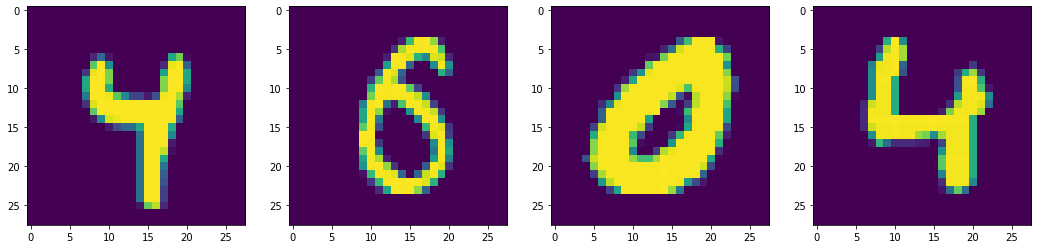

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from models.MNISTNet import MNISTNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
from data.datasets import MNIST
np.random.seed(5242)

mnist = MNIST()
mnist.load()
idx = np.random.randint(mnist.num_train, size=4)
print('\nFour examples of training images:')
img = mnist.x_train[idx][:,0,:,:]

plt.figure(1, figsize=(18, 18))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.subplot(1, 4, 2)
plt.imshow(img[1])
plt.subplot(1, 4, 3)
plt.imshow(img[2])
plt.subplot(1, 4, 4)
plt.imshow(img[3])

In [6]:
from nn.optimizers import RMSprop, Adam

model = MNISTNet()
loss = SoftmaxCrossEntropy(num_class=10)

# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

adam = Adam(lr=0.001, decay=0,  sheduler_func=None, bias_correction=True)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, loss=loss, regularization=l2)

import time
start = time.time()
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=50, val_batch=1000, test_batch=1000, 
    epochs=2, 
    val_intervals=-1, test_intervals=900, print_intervals=100)
print('cost:', time.time()-start)

Epoch 0: 
Train iter 100/960:	acc 0.10, loss 2.30, reg loss 0.00, speed 544.28 samples/sec
Train iter 200/960:	acc 0.12, loss 2.27, reg loss 0.00, speed 511.94 samples/sec
Train iter 300/960:	acc 0.68, loss 1.04, reg loss 0.02, speed 498.90 samples/sec
Train iter 400/960:	acc 0.80, loss 0.59, reg loss 0.02, speed 567.54 samples/sec
Train iter 500/960:	acc 0.90, loss 0.61, reg loss 0.02, speed 466.33 samples/sec
Train iter 600/960:	acc 0.80, loss 0.60, reg loss 0.02, speed 559.26 samples/sec
Train iter 700/960:	acc 0.84, loss 0.51, reg loss 0.02, speed 481.68 samples/sec
Train iter 800/960:	acc 0.88, loss 0.35, reg loss 0.03, speed 484.58 samples/sec
Test acc 0.89, loss 0.37
Train iter 900/960:	acc 0.82, loss 0.54, reg loss 0.03, speed 276.23 samples/sec
Epoch 1: 
Train iter 100/960:	acc 0.90, loss 0.36, reg loss 0.03, speed 508.13 samples/sec
Train iter 200/960:	acc 0.94, loss 0.22, reg loss 0.03, speed 551.94 samples/sec
Train iter 300/960:	acc 0.92, loss 0.26, reg loss 0.03, speed 56

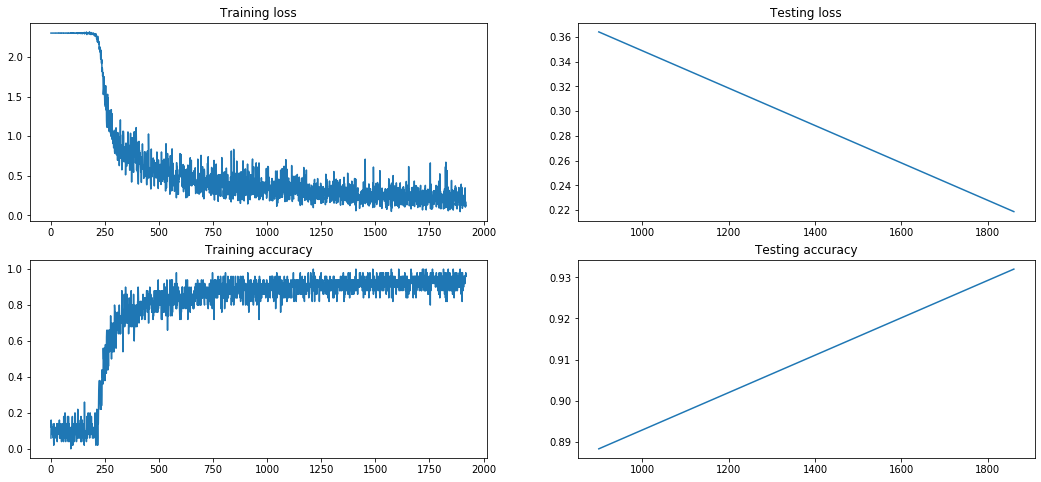

In [3]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

## GRU layer
The GRU layer calls the forward and backward functions of the gru operator in [nn/operators.py](nn/operators.py) to do the real operation.

### Forward function of gru operator

In the file [nn/operators.py](nn/operators.py), implement the forward function for `gru` operation. (`input` is a list of two numpy arrays, `[x, h]`). 

The following cell test the implementation.

In [6]:
import numpy as np
import keras
from keras import layers
from nn.layers import GRUCell
from utils.tools import rel_error

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))

gru_cell = GRUCell(in_features=D, units=H)
out = gru_cell.forward([x, prev_h])
# compare with the keras implementation
keras_x = layers.Input(shape=(1, D), name='x')
keras_prev_h = layers.Input(shape=(H,), name='prev_h')
keras_rnn = layers.GRU(units=H, use_bias=False, recurrent_activation='sigmoid')(keras_x, initial_state=keras_prev_h)
keras_model = keras.Model(inputs=[keras_x, keras_prev_h], 
                          outputs=keras_rnn)
keras_model.layers[2].set_weights([gru_cell.kernel,
                                   gru_cell.recurrent_kernel])
keras_out = keras_model.predict_on_batch([x[:, None, :], prev_h])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 3.7060555998283674e-08


### Backward function of gru operator

Implement the backward function for the `gru` operation in the file [nn/operators.py](nn/operators.py). 

In [7]:
import numpy as np
from nn.layers import GRUCell
from utils.check_grads_rnn import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

gru_cell = GRUCell(in_features=D, units=H)

check_grads_layer(gru_cell, [x, prev_h], in_grads)

Gradient to input 0: correct
Gradient to input 1: correct
Gradient to -:gru_cell/kernel: correct
Gradient to -:gru_cell/recurrent_kernel: correct


## BiRNN layer

Vallina RNN operates over input sequence in one direction, so it has limitations as the future input information cannot be reached from the current state. On the contrary, Bi-directional RNN addresses this shortcoming by operating the input sequence in both forward and backward directions. 

Usually, Bi-directional RNN is implemented by running two independent RNNs in opposite direction of the input data, and concatenating the outputs of the two RNNs. The following function reverses a batch of sequence data  which is necessary for implementing Bi-directional RNN.

```python
def _reverse_temporal_data(self, x, mask):
    num_nan = np.sum(~mask, axis=1)
    reversed_x = np.array(x[:, ::-1, :])
    for i in range(num_nan.size):
        reversed_x[i] = np.roll(reversed_x[i], x.shape[1]-num_nan[i], axis=0)
    return reversed_x
```

### Forward function of BiRNN layer

Use the following code for testing. Note that `H` is the dimension of the hidden states of one internal RNN, so the actual dimension of the hidden states (or outputs) of Bidirectional RNN is `2*H`.

In [8]:
import numpy as np
import keras
from keras import layers
from nn.layers import BiRNN
from utils.tools import rel_error

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))
hr = np.random.uniform(size=(H,))

brnn = BiRNN(in_features=D, units=H, h0=h0, hr=hr)
out = brnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_hr = layers.Input(shape=(H,), name='hr')
keras_x_masked = layers.Masking(mask_value=0.)(keras_x)
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True)
keras_brnn = layers.Bidirectional(keras_rnn, merge_mode='concat', name='brnn')(
        keras_x_masked, initial_state=[keras_h0, keras_hr])
keras_model = keras.Model(inputs=[keras_x, keras_h0, keras_hr],
                          outputs=keras_brnn)
keras_model.get_layer('brnn').set_weights([brnn.forward_rnn.kernel,
                                           brnn.forward_rnn.recurrent_kernel, 
                                           brnn.forward_rnn.bias,
                                           brnn.backward_rnn.kernel, 
                                           brnn.backward_rnn.recurrent_kernel,
                                           brnn.backward_rnn.bias])
keras_out = keras_model.predict_on_batch([np.nan_to_num(x), np.tile(h0, (N, 1)), np.tile(hr, (N, 1))])
nan_indices = np.where(np.any(np.isnan(x), axis=2))
keras_out[nan_indices[0], nan_indices[1], :] = np.nan

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 5.510201111235325e-08


## Sentiment analysis using RNNs

In this section, implement a RNN model for sentiment analysis. The dataset, `data/corpus.csv`, consists of 800 real movie comments and the corresponding labels that indicate whether the comments are positive or negative. For example:
```
POSTIVE: I absolutely LOVE Harry Potter, as you can tell already.
NEGATIVE: My dad's being stupid about brokeback mountain...
```

The input to the network is a sequence of one-hot vectors, each of which represents a word. The 1st Linear layer works as an embedding layer. After a Bi-directional RNN layer and another Linear layer, a TemporalPooling layer is used to aggregate the vectors into one vector, which skips `NaN`s. The rest of the network is the same as a normal classifier.

In [12]:
from data import datasets
from models.SentimentNet import SentimentNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.01, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=5, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

[nltk_data] Downloading package punkt to /Users/shuyao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of training samples: 600
Number of validation samples: 100
Number of testing samples: 100
Epoch 0: 
Train iter 5/30:	acc 0.75, loss 0.66, reg loss 0.01, speed 57.07 samples/sec
Train iter 10/30:	acc 0.75, loss 0.57, reg loss 0.01, speed 67.87 samples/sec
Train iter 15/30:	acc 0.45, loss 0.70, reg loss 0.01, speed 64.85 samples/sec
Train iter 20/30:	acc 0.55, loss 0.72, reg loss 0.01, speed 53.16 samples/sec
Test acc 0.60, loss 0.67
Train iter 25/30:	acc 0.50, loss 0.73, reg loss 0.00, speed 34.67 samples/sec
Epoch 1: 
Train iter 5/30:	acc 0.55, loss 0.62, reg loss 0.03, speed 35.44 samples/sec
Train iter 10/30:	acc 0.90, loss 0.38, reg loss 0.04, speed 58.62 samples/sec
Train iter 15/30:	acc 0.95, loss 0.21, reg loss 0.07, speed 40.75 samples/sec
Train iter 20/30:	acc 0.95, loss 0.12, reg loss 0.12, speed 44.65 samples/sec
Test acc 0.92, loss 0.29
Train iter 25/30:	acc 1.00, loss 0.03, reg loss 0.15, speed 33.10 samples/sec
Epoch 2: 
Train iter 5/30:	acc 1.00, loss 0.12, reg los

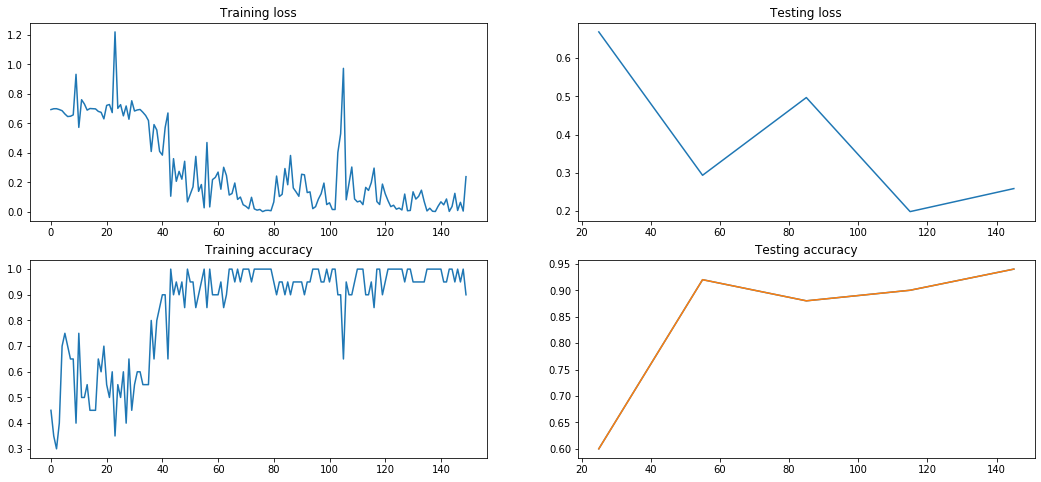

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])